# EDA&ML on Housing Price📈

## Tables of the Contents
1. Import Libraries & Load Datasets
2. EDA and Data Preprocessing
3. Modeling
4. Evaluation
5. Make submission


## 1. Import libraries & Load Dataset

In [16]:

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import math

# preprocessing

from sklearn.preprocessing import RobustScaler
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
dir = "/kaggle/input/2019-2nd-ml-month-with-kakr/"

train = pd.read_csv(dir + "train.csv")
test = pd.read_csv(dir + 'test.csv')

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [18]:
# splitting label
y = train['price']
train_X = train.drop(['price'], axis=1)

train_X.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- It seems necessary that Preprocessing to remove meaningless information from the 'date' column.
- 'id' feature seems unnecessary.

In [19]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non-null  int64  
 12  sqft_basement  15035 non-null  int64  
 13  yr_built       15035 non-null  int64  
 14  yr_renovated   15035 non-null  int64  
 15  zipcode        15035 non-null  int64  
 16  lat            15035 non-null  float64
 17  long           15035 non-null  float64
 18  sqft_l

The meaning of each feature is as follows.

1. ID : id of each house
2. date : the date of buying the house
3. price : price of house. target value
4. bedrooms : the number of bedrooms
5. bathrooms : the number of bathrooms per bedroom
6. sqft_living : square feet of living space
7. sqft_lot : square feet of lot
8. floors : number of floors in the house
9. waterfront : Whether or not there is a river flowing in front of the house
10. view : degree of how good a house looks
11. condition : overall condition of the house
12. grade : Homes are graded using the King County grading system.
13. sqft_above : Square Feet Excluding Basement
14. sqft_basement : Square Feet of Basement
15. yr_built : year the house was built
16. yr_renovated : Year the house was rebuilt
17. zipcode : zip code
18. lat : latitude
19. long : longitude
20. sqft_living15 : Nearby 15 units of living space, square feet
21. sqft_lot15 : Lot of nearby 15 units, sq ft

## 2. EDA and Data Preprocessing on House Price

- concat train and test data
- Handling missing values
- Handing 'id' and 'date' feature
- check the distribution and if necessary, do normalization
- check correlation and do feature selection



In [20]:
# for EDA, concat train and test data
train_len = len(train_X)
df = pd.concat((train_X, test), axis=0)

print('train shape:', train_X.shape)
print('test shape:', test.shape)
print('df shape:', df.shape)

train shape: (15035, 20)
test shape: (6468, 20)
df shape: (21503, 20)


id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


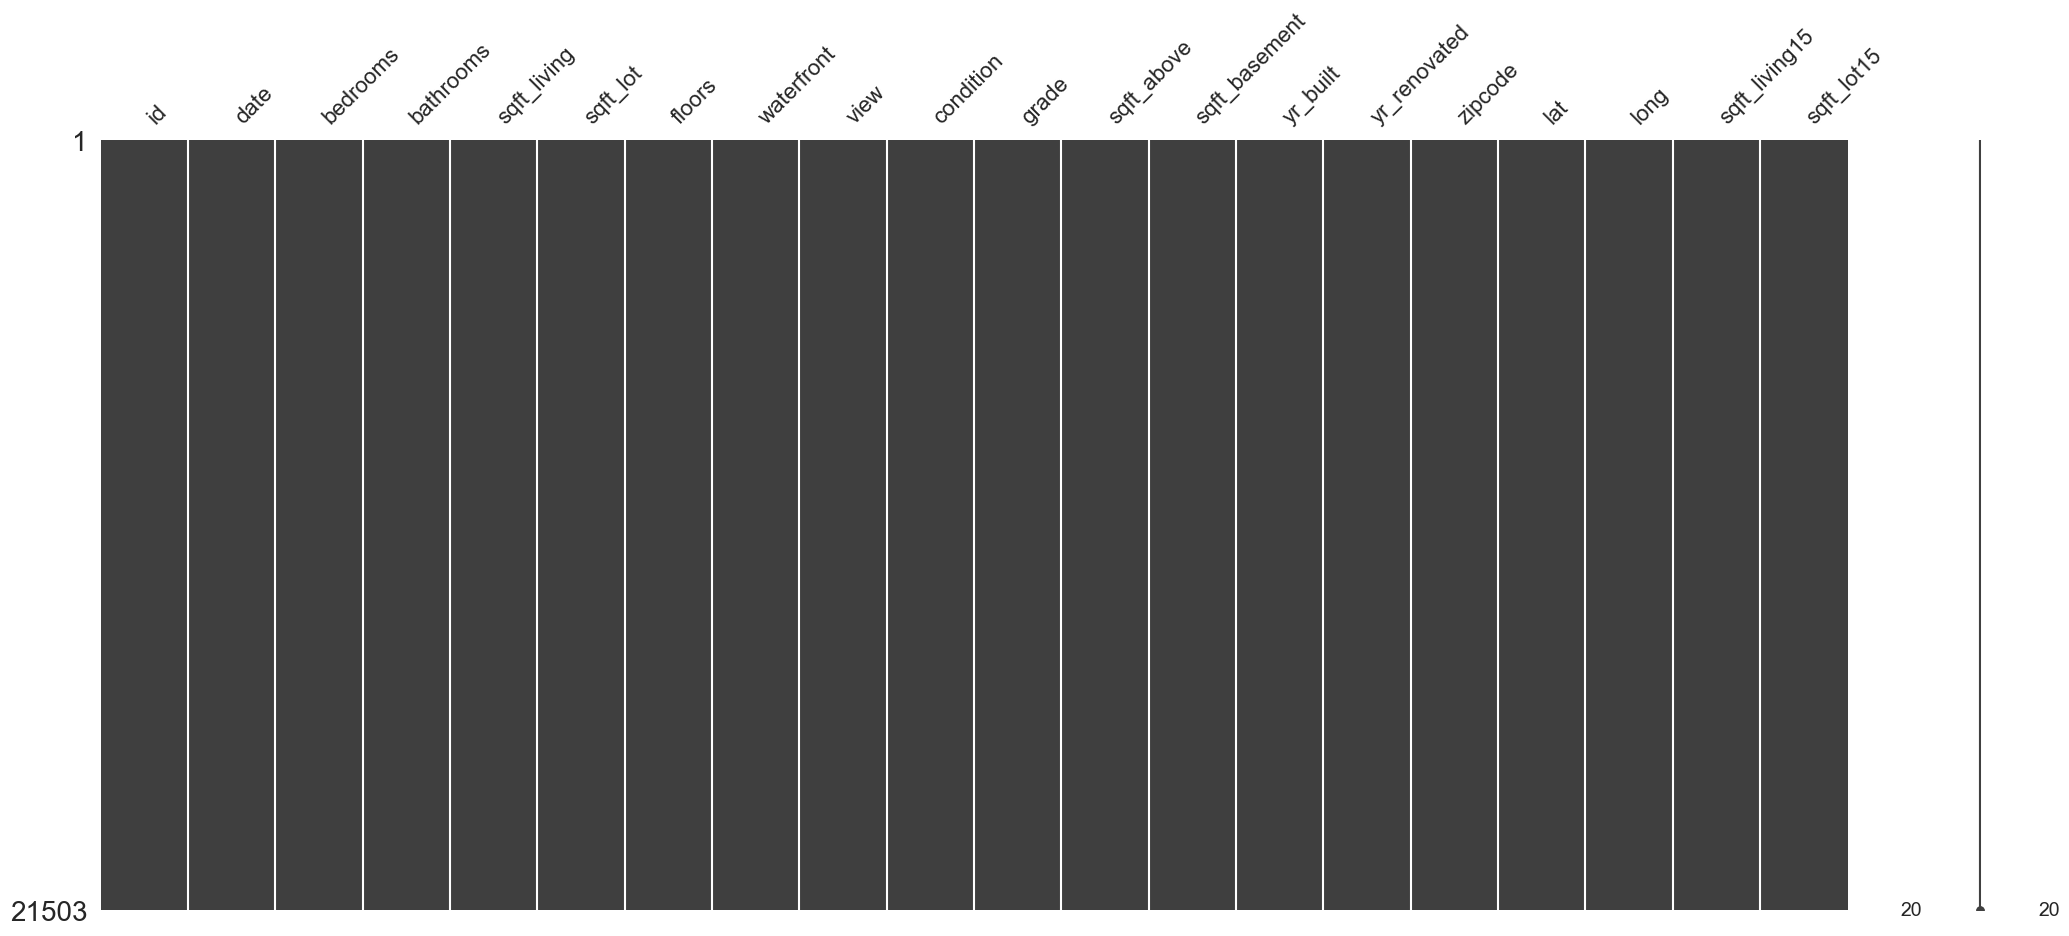

In [21]:
# handling missing values

def check_missing(data):
    msno.matrix(data)
    
    # double check!
    for c in data.columns:
        print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

check_missing(df)

There is any missing value!

In [22]:
# Handing 'id' and date
sub_id = df['id'][train_len:]

def handle_id_date(df):
    df['date'] = df['date'].apply(lambda x: str(x[:6])).astype(int)
    
    if 'id' in df.columns:
        del df['id']

    return df


In [23]:
handle_id_date(df)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


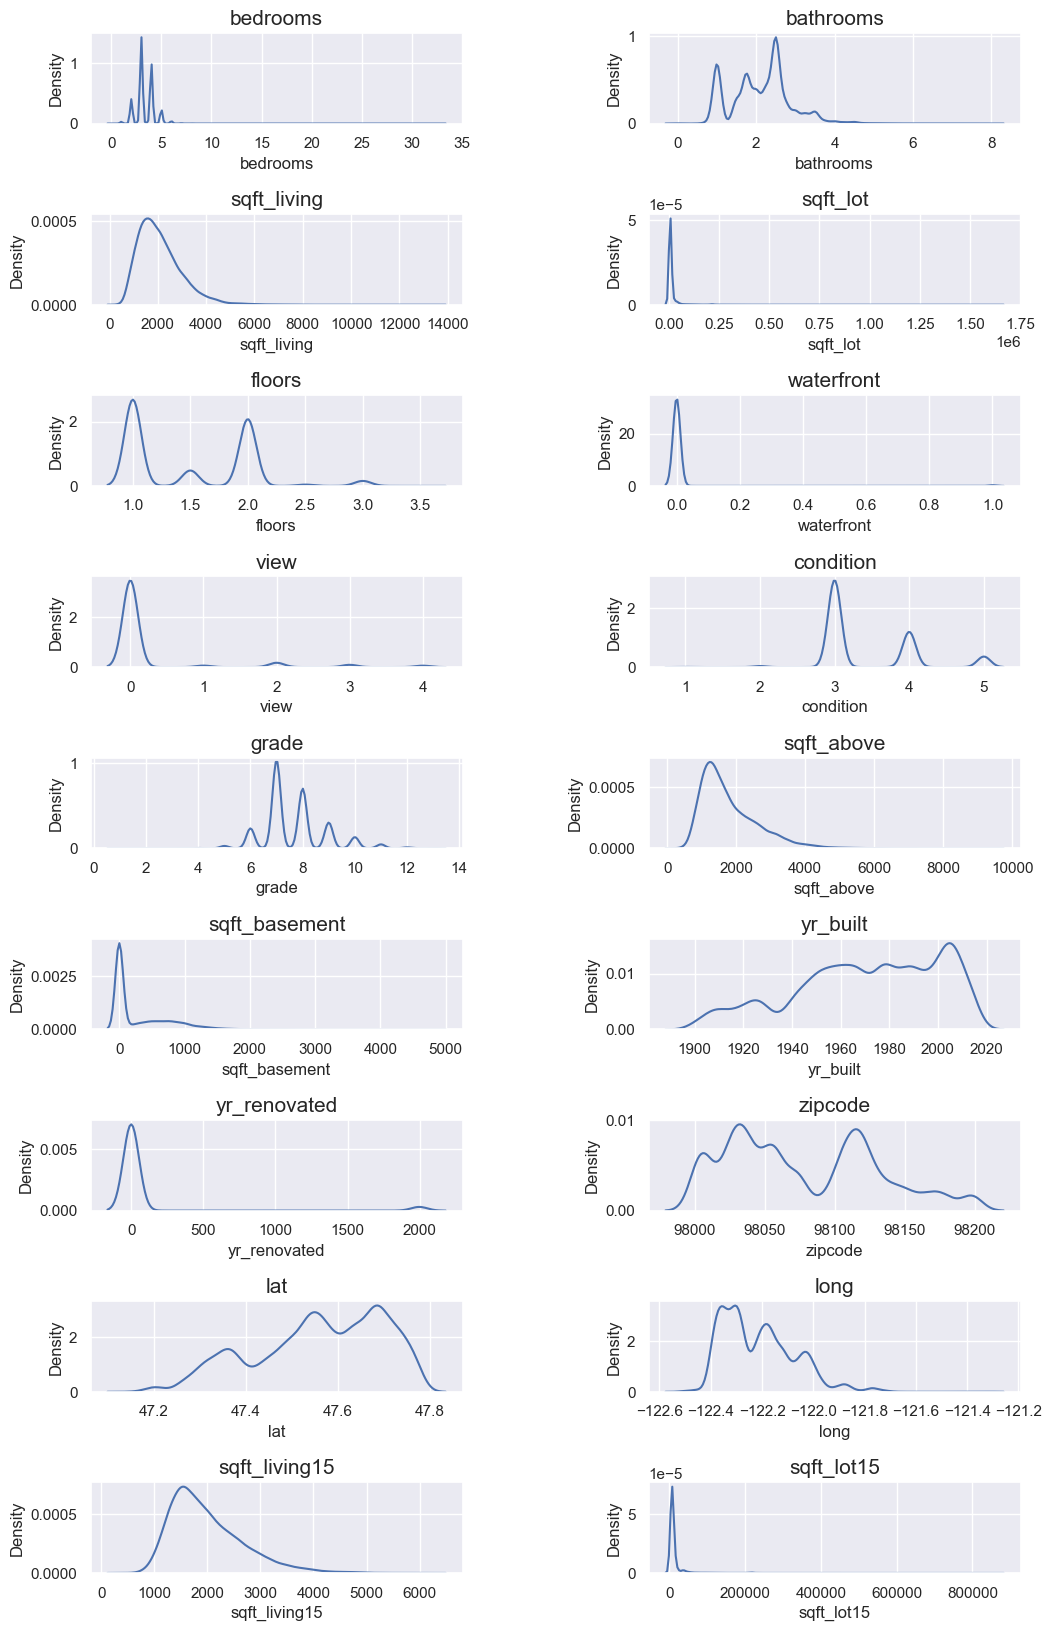

In [24]:
# check distribution

def check_distribution(df, col=1):
    row = int(df.shape[1] / col)

    count = 1
    columns = df.columns
    
    fig, ax = plt.subplots(row, col, figsize=(12,20))
    for i in range(row):
        for j in range(col):
            sns.kdeplot(data=df[columns[count]], ax=ax[i][j])
            ax[i][j].set_title(columns[count], fontsize=15)
            count += 1
            if count == df.shape[1]:
                break
    plt.subplots_adjust(wspace=0.5, hspace=1)
                
check_distribution(df, col=2)
            

- It seems that bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement features are skewd. so do log scaling

In [25]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

def log_scaling(data, skew_columns):
    for c in skew_columns:
        data[c] = np.log1p(data[c].values)
    return data

log_scaling(df, skew_columns)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,1.386294,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,1.386294,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,1.386294,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,1.098612,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299,1020,2007


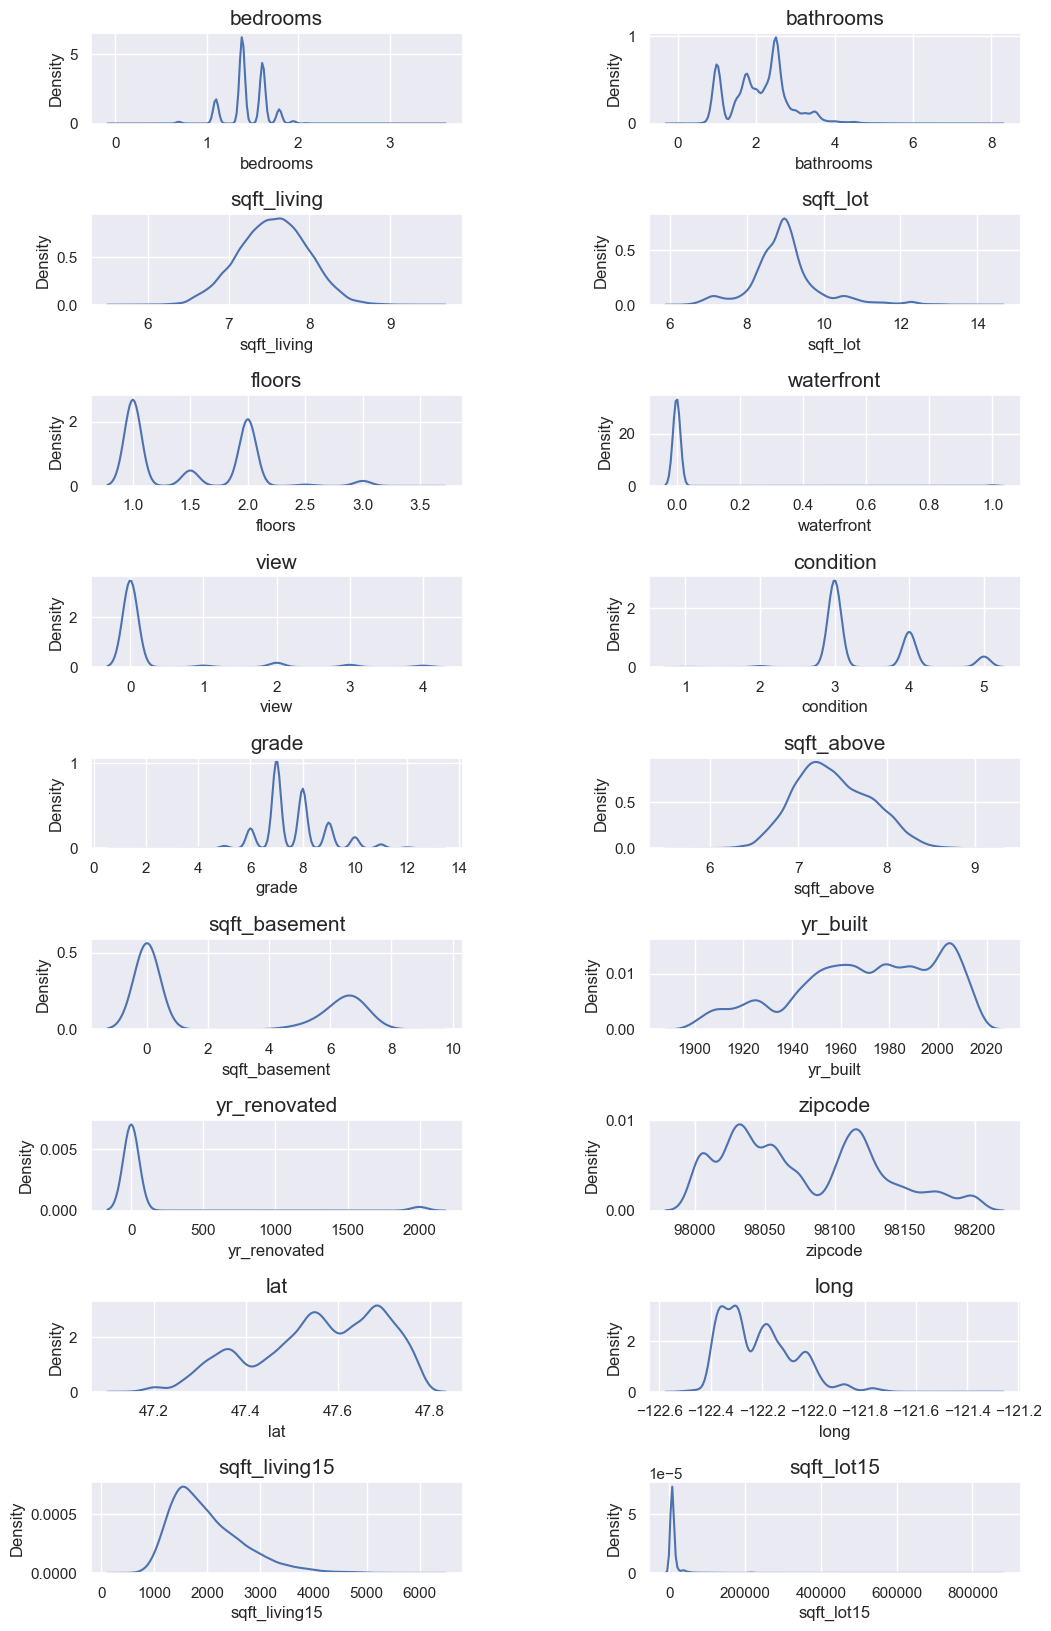

In [26]:
check_distribution(df, col=2)


It seems large that the difference in distribution between the values of each feature. so do normalization

In [27]:
# use robustscaler: minimize the impact of outliers

def robust_scale(df):
    robustscaler = RobustScaler()
    robustscaler.fit(df)

    df = robustscaler.transform(df) 
    return df


In [28]:
robust_scale(df)

array([[ 0.        ,  0.        , -1.66666667, ..., -0.13300493,
        -0.56818182, -0.39518556],
       [ 0.96842105, -1.28922423, -1.66666667, ..., -0.01477833,
         1.        ,  0.088666  ],
       [ 0.96842105,  0.        , -0.33333333, ...,  0.91133005,
        -0.04545455, -0.02347041],
       ...,
       [ 0.96842105,  0.        ,  0.33333333, ..., -0.8817734 ,
        -0.57954545, -1.27482447],
       [-0.04210526, -1.28922423, -2.        , ..., -0.33990148,
        -0.93181818, -1.12597793],
       [ 0.95789474,  0.        ,  0.33333333, ...,  0.79310345,
        -0.48863636, -1.27041123]])

#### check correlation

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


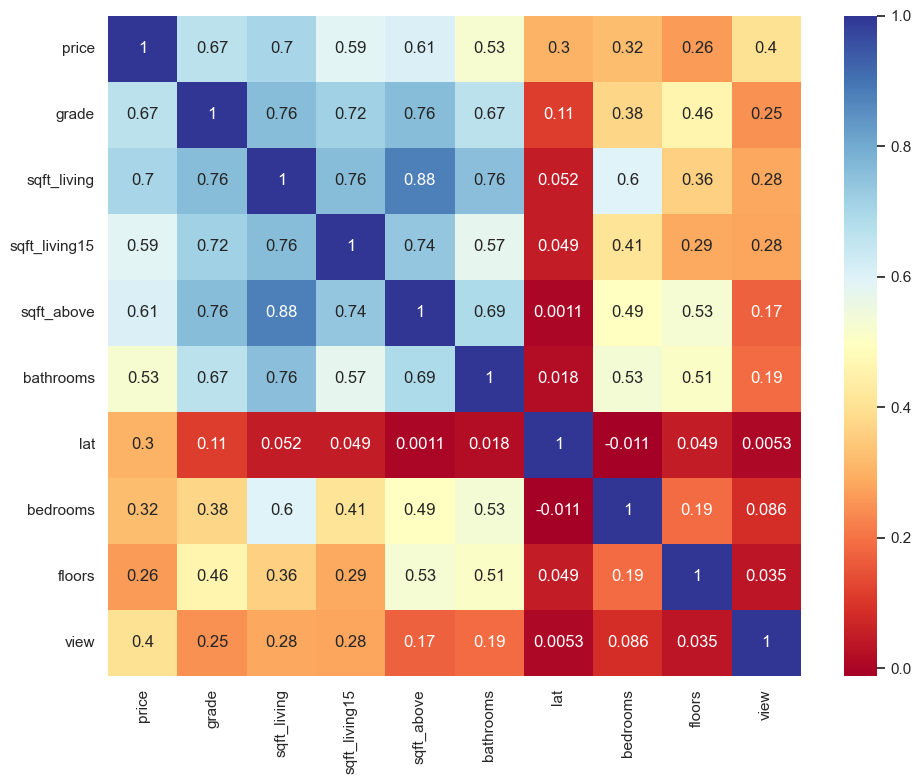

In [29]:
fig = plt.figure(figsize = (10, 8))
ax = fig.gca()
train['date'] = train['date'].apply(lambda x: str(x[:6])).astype(int)

cor_abs = abs(train.corr(method='spearman')) 

cor_cols = cor_abs.nlargest(n=10, columns='price').index
columns = cor_cols.values

print(columns)

sns.set()
corr = train[columns].corr(method='pearson')
heatmap = sns.heatmap(corr, annot=True,
                      yticklabels=columns, 
                      xticklabels=columns,
                      ax=ax, cmap="RdYlBu")
plt.tight_layout()
plt.show()

The factors that greatly affect the price of a house seem to be, in order, the grade of the house, the size of the house, and the location.

In [30]:
test = df.iloc[train_len:, :] 
train = df.iloc[:train_len, :]

test.shape

(6468, 19)

In [31]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,1650,9711


<Axes: xlabel='price', ylabel='Density'>

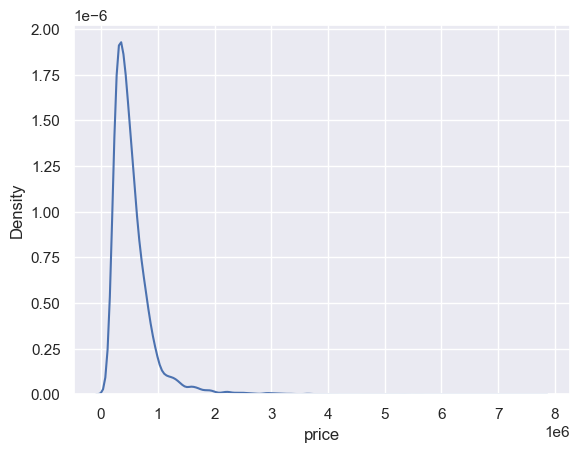

In [32]:
sns.kdeplot(data=y)


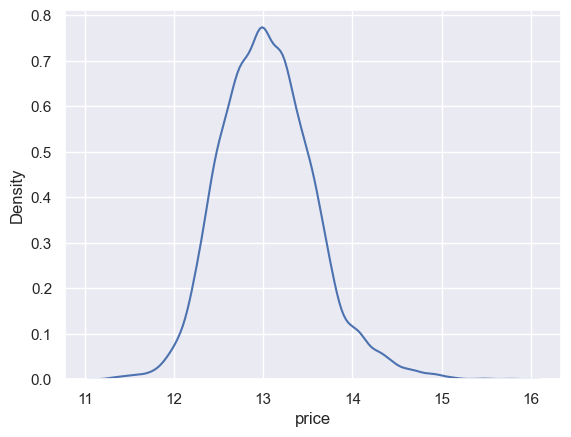

In [33]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

## 3. Modeling

In [34]:

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [35]:
random_state = 42

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [36]:

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,141519.932436
GradientBoostingRegressor,134139.377568
XGBRegressor,126741.713670
LGBMRegressor,123074.595390


#### grid search

In [37]:
def get_gs_result(
    model, train, y, param_grid={'n_estimators': [50, 100], 'max_depth': [1, 10] }, verbose=2, n_jobs=5):
    
    grid_model = GridSearchCV(
        model, param_grid=param_grid, 
        scoring='neg_mean_squared_error', 
        cv=5, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [38]:
get_gs_result(
    LGBMRegressor(random_state=random_state), train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.3s
[CV] END ...................

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164389
2,10,50,-0.029173,0.170802
1,1,100,-0.055023,0.234570
0,1,50,-0.073398,0.270920


In [39]:
get_gs_result(
    XGBRegressor(random_state=random_state), train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.9s
[CV] END ......................max_depth=10, n_es

,max_depth,n_estimators,score,RMSLE
2,10,50,-0.030351,0.174216
3,10,100,-0.030595,0.174916
1,1,100,-0.043012,0.207394
0,1,50,-0.048726,0.220739


In [40]:
get_gs_result(
    RandomForestRegressor(random_state=random_state), train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=10, n_estimators=50; total time=   2.2s
[CV] END ......................max_depth=10, n_es

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.035151,0.187485
2,10,50,-0.035341,0.187993
0,1,50,-0.178965,0.423043
1,1,100,-0.179058,0.423153


In [41]:
# GradientBoostingRegressor Model
get_gs_result(
    GradientBoostingRegressor(random_state=random_state), train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.8s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.8s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.8s
[CV] END ......................max_depth=10, n_estimators=50; total time=   3.4s
[CV] END ......................max_depth=10, n_es

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.029461,0.171642
2,10,50,-0.029906,0.172935
1,1,100,-0.055039,0.234603
0,1,50,-0.073256,0.270658


### ensemble

In [42]:
from sklearn.ensemble import StackingRegressor

def get_stacking_model():
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    gboost = GradientBoostingRegressor(random_state=random_state)
    xgboost = XGBRegressor(random_state=random_state)
    lightgbm = LGBMRegressor(random_state=random_state)
    rdforest = RandomForestRegressor(random_state=random_state)

    stack_models = [
        ('gb', gboost),
        ('xgb', xgboost),
        ('lgbm', lightgbm),
        ('rf', rdforest)
    ]
    
    stack_reg = StackingRegressor(stack_models, final_estimator=gboost)
    stack_reg.fit(X_train, y_train)
    
    y_pred = stack_reg.predict(X_test)
    print(f'rmse: {rmse(y_pred, y_test)}')
    
    return stack_reg

s_model = get_stacking_model()

rmse: 123088.60063110589


In [43]:
#def AveragingBlending(models, x, y, sub_x):
#    for m in models : 
#        m['model'].fit(x.values, y)
    
#    predictions = np.column_stack([
#        m['model'].predict(sub_x.values) for m in models
#    ])
#    return np.mean(predictions, axis=1)

In [47]:
#y_pred = AveragingBlending(s_model, test, y, sub)


TypeError: 'StackingRegressor' object is not iterable

## submission

In [48]:
def save_submission(model, test):
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    sub = pd.DataFrame(data={'id':sub_id,'price':prediction})
    sub.to_csv('submission.csv', index=False)
    print('submission complete!')

In [49]:
save_submission(s_model, test)

submission complete!
